# Libraries

In [1]:
!pip install wfdb

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from sklearn.linear_model import Ridge
from matplotlib.colors import Normalize
import networkx as nx
from scipy.signal import welch
import matplotlib.cm as cm
import seaborn as sns
from collections import defaultdict
from sklearn.decomposition import PCA

# Utils

In [3]:
def scale_spectral_radius(W, target_radius=0.95):
    eigvals = np.linalg.eigvals(W)
    radius = np.max(np.abs(eigvals))
    if radius == 0:
        return W
    return (W / radius) * target_radius

In [4]:
def hyperbolic_distance_poincare(u, v):
    """
    Compute the hyperbolic distance d(u, v) in the Poincaré disk model (2D).
    Both u, v in R^2 with ||u|| < 1, ||v|| < 1.
    Formula: 
      d(u,v) = arcosh(1 + 2 * ||u - v||^2 / ((1 - ||u||^2)*(1 - ||v||^2)))
    If either point is near radius=1, numerical instability might occur. 
    """

    norm_u_squared = np.dot(u, u)
    norm_v_squared = np.dot(v, v)
    
    # clamp to avoid negative denominators if norms ~1
    eps = 1e-14
    one_minus_u = max(eps, 1.0 - norm_u_squared)
    one_minus_v = max(eps, 1.0 - norm_v_squared)
    
    diff = u - v
    diff_squared = np.dot(diff, diff)  # Euclidean squared
    
    arg = 1.0 + 2.0 * diff_squared / (one_minus_u * one_minus_v)
    if arg < 1.0:
        arg = 1.0
    return np.arccosh(arg)

In [5]:
def plot_poincare_geodesic(p, q, ax, n_points=200, **kw):
    """
    Plot a geodesic between two points p and q on the Poincaré disk.
    
    Parameters:
    - p, q: np.array of shape (2,), points in the Poincaré disk
    - ax: matplotlib axis to plot on
    - n_points: number of points to use for the geodesic arc
    - **kw: keyword arguments passed to ax.plot
    
    Returns:
    - None, plots the geodesic on the given axis
    """
    
    # Ensure points are within the disk
    p_norm = np.linalg.norm(p)
    q_norm = np.linalg.norm(q)
    if p_norm >= 1.0 or q_norm >= 1.0:
        raise ValueError("Points must be within the unit disk")
    
    # Check if points are on a diameter (geodesic is a straight line)
    if np.isclose(np.linalg.norm(np.cross(np.append(p, 0), np.append(q, 0))), 0):
        ax.plot([p[0], q[0]], [p[1], q[1]], **kw)
        return
    
    # For non-diametric geodesics, we need to find the circle
    # orthogonal to the unit circle and passing through p and q
    
    # Möbius transformation approach
    x1, y1 = p
    x2, y2 = q
    
    # Calculate circle parameters
    # We're looking for a circle that is orthogonal to the unit circle
    # and passes through p and q
    
    # This is a circle with center c and radius r such that:
    # |c|^2 - r^2 = 1 (orthogonality condition)
    # |p - c|^2 = r^2 and |q - c|^2 = r^2 (p and q are on the circle)
    
    # Set up the linear system for finding the center
    A = np.array([
        [2*(x2 - x1), 2*(y2 - y1)],
        [2*x1, 2*y1]
    ])
    
    b = np.array([
        x2**2 + y2**2 - x1**2 - y1**2,
        1 + x1**2 + y1**2
    ])
    
    # Solve for the center c
    try:
        c = np.linalg.solve(A, b)
    except np.linalg.LinAlgError:
        # If the system is singular, the points are on a straight line through the origin
        ax.plot([p[0], q[0]], [p[1], q[1]], **kw)
        return
    
    # Calculate radius
    r = np.sqrt(np.sum((p - c)**2))
    
    # Determine the angles for the arc
    theta1 = np.arctan2(p[1] - c[1], p[0] - c[0])
    theta2 = np.arctan2(q[1] - c[1], q[0] - c[0])
    
    # Ensure we take the shortest path (the arc that stays within the disk)
    # The key insight: we want the arc that stays inside the unit disk
    delta_theta = (theta2 - theta1) % (2 * np.pi)
    if delta_theta > np.pi:
        delta_theta = delta_theta - 2 * np.pi
    
    # If the center is far away, we might need to reverse the direction
    # to ensure we stay inside the unit disk
    mid_theta = theta1 + delta_theta/2
    mid_point = c + r * np.array([np.cos(mid_theta), np.sin(mid_theta)])
    if np.linalg.norm(mid_point) > 1:
        delta_theta = -delta_theta
    
    # Generate points along the arc
    thetas = np.linspace(theta1, theta1 + delta_theta, n_points)
    arc_points = c.reshape(2, 1) + r * np.vstack([np.cos(thetas), np.sin(thetas)])
    
    # Filter points to ensure they're within the unit disk
    mask = (arc_points[0]**2 + arc_points[1]**2) < 1 - 1e-10
    
    # Plot the geodesic arc
    ax.plot(arc_points[0, mask], arc_points[1, mask], **kw)
    
    return arc_points[:, mask]


def draw_hyperbolic_reservoir(positions, W, save_path="Figures/hyperbolic_reservoir.png"):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
    ax.set_frame_on(False)
    ax.add_patch(plt.Circle((0, 0), 1, color='black', fill=False, linestyle='dashed'))

    radial_distances = np.linalg.norm(positions, axis=1)
    norm = Normalize(vmin=0, vmax=np.max(radial_distances))
    cmap = plt.get_cmap("twilight_r")

    G = nx.Graph()
    N = len(positions)
    for i in range(N):
        G.add_node(i, pos=positions[i])
    
    
    for i in range(N):
        for j in range(N):
            if W[i, j] > 0:
                # Use _plot_geodesic to draw hyperbolic geodesic path
                p = positions[i]
                q = positions[j]
                plot_poincare_geodesic(p, q, ax, color=(0, 49/255, 83/255, min(W[i, j]*300.0, 1.0)))

    for i in range(N):
        ax.scatter(positions[i, 0], positions[i, 1], color=cmap(0.97), s=50, edgecolors='k', linewidth=0.5, zorder=2)

    # sm = ScalarMappable(cmap=cmap, norm=norm)
    # sm.set_array([])
    # cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
    # cbar.set_label("Radial Distance")
    
    plt.savefig(save_path, dpi=600, bbox_inches='tight')
    plt.show()


In [6]:
def plot_pca_projection3d(states):
    # Apply PCA for 3D visualization
    pca = PCA(n_components=3)
    proj = pca.fit_transform(states)

    sns.set_theme(style="white")
    fig = plt.figure(figsize=(12, 9))  # Increased width for padding
    ax = plt.axes(projection='3d')

    # Scatter plot
    p = ax.scatter(proj[:, 0], proj[:, 1], proj[:, 2], 
                   c=np.arange(len(proj)), cmap='viridis', s=2.5)

    # Axis labels with padding
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")

    cbar = fig.colorbar(p, ax=ax, shrink=0.6, pad=0.1)
    cbar.set_label("Index progression")
    
    plt.savefig('Figures/PCA_projection_2d_rossler_hyper.png', dpi=600)
    plt.show()

In [7]:
def plot_pca_projection2d(states):
    # Apply PCA for 3D visualization
    pca = PCA(n_components=2)
    proj = pca.fit_transform(states)

    sns.set_theme(style="white")
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111)
    p = ax.scatter(proj[:, 0], proj[:, 1], c=np.arange(len(proj)), cmap='plasma', s=2.5)

    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    plt.savefig('Figures/PCA_projection_3d_rossler_hyper.png', dpi=600)
    plt.show()

In [8]:
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec

def visualize_sparsity(matrix1, matrix2):
        combined = np.stack([matrix1, matrix2])
        min_nonzero = np.min(combined[combined > 0])
        small_value = min_nonzero / 1000
        vmax = np.max(combined)
        norm = colors.LogNorm(vmin=small_value, vmax=vmax)

        # Setup figure and gridspec
        fig = plt.figure(figsize=(20, 8))
        gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.05], wspace=0.05)

        ax1 = plt.subplot(gs[0])
        ax2 = plt.subplot(gs[1])
        cbar_ax = plt.subplot(gs[2])  # This will span the full vertical height

        # Plot first matrix
        sns.heatmap(matrix1, cmap='twilight', ax=ax1, norm=norm, mask=(matrix1 == 0), cbar=False)
        ax1.axis('off')

        # Plot second matrix
        sns.heatmap(matrix2, cmap='twilight', ax=ax2, norm=norm, mask=(matrix2 == 0),
                        cbar=True, cbar_ax=cbar_ax)
        ax2.axis('off')
        plt.savefig('Figures/Sparsity Visualization.png', dpi=600)
        plt.show()

In [9]:
def create_delay_embedding(signal, embed_dim):
    L = len(signal) - embed_dim + 1
    emb = np.zeros((L, embed_dim))
    for i in range(L):
        emb[i, :] = signal[i:i+embed_dim]
    return emb

# Baselines

### Baseline ESN

In [10]:
class BaselineESN3D:
    """
    A baseline Echo State Network that handles:
        - 3D input (x,y,z)
        - 3D output (x(t+1), y(t+1), z(t+1))"
    """
    def __init__(self,
                 reservoir_size=400,
                 spectral_radius=0.95,
                 connectivity=0.1,
                 input_scale=1.0,
                 leaking_rate=0.8,
                 ridge_alpha=1e-6,
                 activation_choices=('tanh','relu','sin','linear'),
                 seed=42):
        self.reservoir_size = reservoir_size
        self.spectral_radius = spectral_radius
        self.connectivity = connectivity
        self.input_scale = input_scale
        self.leaking_rate = leaking_rate
        self.ridge_alpha = ridge_alpha
        self.activation_choices = activation_choices
        self.seed = seed

        np.random.seed(self.seed)
        # Initialize W with small random values (mean=0, variance=0.01)
        W = np.random.randn(reservoir_size, reservoir_size) * 0.1
        # Create a boolean sparsity mask
        mask = (np.random.rand(reservoir_size, reservoir_size) < self.connectivity)
        W = W * mask
        W = scale_spectral_radius(W, self.spectral_radius)
        self.W = W

        np.random.seed(self.seed + 100)
        # Initialize input weights in range [-input_scale, input_scale]
        self.W_in = (np.random.rand(self.reservoir_size, 3) - 0.5) * 2.0 * self.input_scale

        np.random.seed(self.seed + 200)
        self.node_activations = np.random.choice(self.activation_choices, size=self.reservoir_size)

        # Readout: shape (3, reservoir_size+1) -> 3D output
        self.W_out = None
        self.reset_state()

    def reset_state(self):
        self.x = np.zeros(self.reservoir_size)

    def _apply_activation(self, act_type, val):
        return np.tanh(val)
        # if act_type=='tanh':
        #     return np.tanh(val)
        # elif act_type=='relu':
        #     return max(0.0, val)
        # elif act_type=='sin':
        #     return np.sin(val)
        # elif act_type=='linear':
        #     return val
        # else:
        #     return np.tanh(val)

    def _update(self, u):
        """
        x(t+1) = (1-alpha)*x(t) + alpha*[ node-by-node activation( W*x(t)+W_in*u ) ]
        """
        pre_activations = self.W @ self.x + self.W_in @ u
        x_new = np.zeros_like(self.x)
        for i in range(self.reservoir_size):
            activation = self.node_activations[i]
            x_new[i] = self._apply_activation(activation, pre_activations[i])
        alpha = self.leaking_rate
        self.x = (1.0 - alpha)*self.x + alpha*x_new
        
    def collect_states(self, inputs, discard=100):
        """
        Run reservoir on 'inputs' (shape [T, 3]), discarding the first 'discard' steps.
        Returns: states [T-discard, reservoir_size]
        """
        self.reset_state()
        states = []
        for t in range(len(inputs)):
            self._update(inputs[t])
            states.append(self.x.copy())
        states = np.array(states)
        return states[discard:], states[:discard]
    

    def fit_readout(self, train_input, train_target, discard=100):
        """
        Teacher forcing for single-step:
            - input(t) = [x(t), y(t), z(t)]
            - target(t) = [x(t+1), y(t+1), z(t+1)]
        We collect states(t), then solve a multi-output linear ridge regression:
            W_out * [x(t); 1] ~ target(t+1).
        For quadratic readout:
            W_out * [x(t); x²(t); 1] ~ target(t+1).
        """
        states_use, _ = self.collect_states(train_input, discard=discard)
        targets_use = train_target[discard:]  # shape [T-discard, 3]

        # Augment states with bias
        # X_aug = np.hstack([states_use, np.ones((states_use.shape[0], 1))])  # shape [T-discard, N+1]

        # Quadratic readout
        # Build augmented matrix [ x, x^2, 1 ]
        X_list = []
        for s in states_use:
            X_list.append( np.concatenate([s, s**2, [1.0]]) )
        X_aug = np.array(X_list)                                # shape [T-discard, 2N+1]

        ridge_reg = Ridge(alpha=self.ridge_alpha, fit_intercept=False)
        ridge_reg.fit(X_aug, targets_use)
        self.W_out = ridge_reg.coef_

    def predict(self, inputs):
        """
        Single-step-ahead inference on test data:
        For each inputs[t], we update reservoir, then read out 3D prediction.
        """
        preds = []
        for t in range(len(inputs)):
            self._update(inputs[t])
            # x_aug = np.concatenate([self.x, [1.0]])
            x_aug = np.concatenate([self.x, (self.x)**2, [1.0]])  # For quadrartic readout
            out = self.W_out @ x_aug
            preds.append(out)
        return np.array(preds)
    
    def autoregressive_predict(self, initial_input, num_steps):
        """
        Autoregressive multi-step forecasting for num_steps
        """
        preds = []
        current_input = initial_input.copy()
      
        for _ in range(num_steps):
            self._update(current_input)
            # x_aug = np.concatenate([self.x, [1.0]])
            x_aug = np.concatenate([self.x, (self.x)**2, [1.0]])  # For quadratic readout
            out = self.W_out @ x_aug
            preds.append(out)
            current_input = out
        
        return np.array(preds)

### SCR

In [11]:
class CycleReservoir3D(BaselineESN3D):
    """
    Cyclic Reservoir for 3D -> 3D Lorenz.
    - reservoir_size, spectral_radius, input_scale, leaking_rate, ridge_alpha as in baseline
    """
    def __init__(self,
                 reservoir_size=400,
                 spectral_radius=0.95,
                 cycle_weight = 0.8,
                 input_scale=1.0,
                 leaking_rate=0.8,
                 ridge_alpha=1e-6,
                 activation_choices=('tanh','relu','sin','linear'),
                 seed=42):
        
        self.reservoir_size = reservoir_size
        self.spectral_radius = spectral_radius
        self.cycle_weight = cycle_weight
        self.input_scale = input_scale
        self.leaking_rate = leaking_rate
        self.ridge_alpha = ridge_alpha
        self.activation_choices = activation_choices
        self.seed = seed

        np.random.seed(self.seed)
        # Build cycle adjacency: W[i,(i+1)%N] = 1
        W = np.zeros((reservoir_size, reservoir_size))
        for i in range(reservoir_size):
            j = (i+1) % reservoir_size
            W[i, j] = cycle_weight

        W = scale_spectral_radius(W, self.spectral_radius)
        self.W = W

        np.random.seed(self.seed + 100)
        # Initialize input weights in range [-input_scale, input_scale]
        self.W_in = (np.random.rand(self.reservoir_size, 3) - 0.5) * 2.0 * self.input_scale

        np.random.seed(self.seed + 200)
        self.node_activations = np.random.choice(self.activation_choices, size=self.reservoir_size)

        # Readout: shape (3, reservoir_size+1) -> 3D output
        self.W_out = None
        self.reset_state()


### CRJ

In [12]:
class CRJRes3D(BaselineESN3D):
    def __init__(self,
                 reservoir_size=300,
                 edge_weight = 0.8,
                 jump=10,
                 spectral_radius=0.95,
                 input_scale=1.0,
                 leaking_rate=1.0,
                 ridge_alpha=1e-6,
                 activation_choices=('tanh','relu','sin','linear'),
                 seed=42):
        
        self.reservoir_size = reservoir_size
        self.edge_weight = edge_weight
        self.jump = jump
        self.spectral_radius = spectral_radius
        self.input_scale = input_scale
        self.leaking_rate = leaking_rate
        self.ridge_alpha = ridge_alpha
        self.activation_choices = activation_choices
        self.seed = seed

        np.random.seed(self.seed)
        W = np.zeros((reservoir_size, reservoir_size))
        for i in range(reservoir_size):
            W[i, (i+1) % reservoir_size] = edge_weight              # Cycle edge
            W[i, (i + self.jump) % reservoir_size] = edge_weight    # Jump edge

        W = scale_spectral_radius(W, self.spectral_radius)
        self.W = W

        np.random.seed(self.seed+100)
        self.W_in = (np.random.rand(self.reservoir_size, 3) - 0.5) * 2.0 * self.input_scale

        np.random.seed(self.seed + 200)
        self.node_activations = np.random.choice(self.activation_choices, size=self.reservoir_size)

        # Readout: shape (3, reservoir_size+1) -> 3D output
        self.W_out = None
        self.reset_state()

### Small-World Res

In [13]:
# class SWRes3D(BaselineESN3D):
#     """
#     Small-World (SW) Reservoir for 3D->3D single-step prediction using the Watts-Strogatz (WS) method.
#     """
#     def __init__(self,
#                  reservoir_size=300,
#                  rewiring_prob=0.1,
#                  degree=6,
#                  spectral_radius=0.95,
#                  input_scale=1.0,
#                  leaking_rate=1.0,
#                  ridge_alpha=1e-6,
#                  activation_choices=('tanh','relu','sin','linear'),
#                  seed=42):

#         self.reservoir_size = reservoir_size
#         self.spectral_radius = spectral_radius
#         self.rewiring_prob = rewiring_prob
#         self.degree = degree
#         self.input_scale = input_scale
#         self.leaking_rate = leaking_rate
#         self.ridge_alpha = ridge_alpha
#         self.activation_choices = activation_choices
#         self.seed = seed

#         np.random.seed(self.seed)
#         # Create a Watts-Strogatz small-world graph
#         ws_graph = nx.watts_strogatz_graph(n=reservoir_size, k=self.degree, p=self.rewiring_prob, seed=self.seed)
#         adjacency_matrix = nx.to_numpy_array(ws_graph)
        
#         # Initialize reservoir weights
#         W = adjacency_matrix * np.random.uniform(-1, 1, (reservoir_size, reservoir_size))
#         W = scale_spectral_radius(W, spectral_radius)
#         self.W = W

#         np.random.seed(self.seed+100)
#         self.W_in = (np.random.rand(reservoir_size, 3) - 0.5) * 2.0 * input_scale

#         np.random.seed(self.seed + 200)
#         self.node_activations = np.random.choice(self.activation_choices, size=self.reservoir_size)

#         self.W_out = None
#         self.reset_state()

### MCI-ESN

In [14]:
class MCIESN3D:
    def __init__(self,
                 reservoir_size=300,
                 cycle_weight=0.8,
                 connect_weight=0.8,
                 combine_factor=0.5,
                 v1=0.6,
                 v2=0.6,
                 spectral_radius=0.95,
                 leaking_rate=1.0,
                 ridge_alpha=1e-6,
                 seed=42
                 ):
        self.reservoir_size = reservoir_size
        self.cycle_weight = cycle_weight
        self.connect_weight = connect_weight
        self.combine_factor = combine_factor
        self.v1 = v1
        self.v2 = v2
        self.spectral_radius = spectral_radius
        self.leaking_rate = leaking_rate
        self.ridge_alpha = ridge_alpha
        self.seed = seed

        np.random.seed(self.seed)
        W_res = np.zeros((reservoir_size, reservoir_size))
        for i in range(reservoir_size):
            j = (i+1) % reservoir_size
            W_res[j, i] = self.cycle_weight

        W_res = scale_spectral_radius(W_res, spectral_radius)
        self.W_res = W_res                      # shared by both sub-reservoirs

        np.random.seed(self.seed + 100)
        W_cn = np.zeros((reservoir_size, reservoir_size))
        W_cn[0, reservoir_size-1] = self.connect_weight
        W_cn[reservoir_size-1, 0] = self.connect_weight
        self.W_cn = W_cn

        np.random.seed(self.seed+200)

        sign_V1 = np.random.choice([-1, 1], size=(reservoir_size, 3))
        sign_V2 = np.random.choice([-1, 1], size=(reservoir_size, 3))

        V1 = self.v1 * sign_V1
        V2 = self.v2 * sign_V2

        self.W_in1 = V1 - V2
        self.W_in2 = V1 + V2
        
        self.W_out = None

    def reset_state(self):
        self.x1 = np.zeros(self.reservoir_size)
        self.x2 = np.zeros(self.reservoir_size)

    def _update(self, u):
        """
        Single-step reservoir update.
        x1(t+1) = cos( Win1*u(t+1) + W_res*x1(t) + W_cn*x2(t) )
        x2(t+1) = sin( Win2*u(t+1) + W_res*x2(t) + W_cn*x1(t) )
        Then x(t+1)= h*x1(t+1) + (1-h)* x2(t+1).
        """
        # pre activation for reservoir1
        pre_activation1 = self.W_in1 @ u + self.W_res @ self.x1 + self.W_cn @ self.x2
        # reservoir1 uses cos
        x1_new = np.cos(pre_activation1)

        # reservoir2 uses sin
        pre_activation2 = self.W_in2 @ u + self.W_res @ self.x2 + self.W_cn @ self.x1
        x2_new = np.sin(pre_activation2)

        alpha = self.leaking_rate
        self.x1 = (1.0 - alpha)*self.x1 + alpha*x1_new
        self.x2 = (1.0 - alpha)*self.x2 + alpha*x2_new

    def _combine_state(self):
        """
        Combine x1(t), x2(t) => x(t) = h*x1(t) + (1-h)*x2(t)
        """
        h = self.combine_factor
        return h*self.x1 + (1.0 - h)*self.x2
    
    def collect_states(self, inputs, discard=100):
        self.reset_state()
        states = []
        for t in range(len(inputs)):
            self._update(inputs[t])
            combined = self._combine_state()
            states.append(combined.copy())
        states = np.array(states)
        return states[discard:], states[:discard]
    
    def fit_readout(self, train_input, train_target, discard=100):
        states_use, _ = self.collect_states(train_input, discard=discard)
        targets_use = train_target[discard:]

        # Augment states with bias
        # X_aug = np.hstack([states_use, np.ones((states_use.shape[0], 1))])  # shape [T-discard, N+1]

        # Quadratic readout
        # Build augmented matrix [ x, x^2, 1 ]
        X_list = []
        for s in states_use:
            X_list.append( np.concatenate([s, s**2, [1.0]]) )
        X_aug = np.array(X_list)                                # shape [T-discard, 2N+1]

        ridge_reg = Ridge(alpha=self.ridge_alpha, fit_intercept=False)
        ridge_reg.fit(X_aug, targets_use)
        self.W_out = ridge_reg.coef_

    def predict(self, inputs):
        preds = []
        for t in range(len(inputs)):
            self._update(inputs[t])
            combined = self._combine_state()
            # x_aug = np.concatenate([self.x, [1.0]])
            x_aug = np.concatenate([combined, combined**2, [1.0]])  # For quadrartic readout
            out = self.W_out @ x_aug
            preds.append(out)
        return np.array(preds)
    
    def autoregressive_predict(self, initial_input, num_steps):
        preds = []
        current_input = initial_input.copy()
      
        for _ in range(num_steps):
            self._update(current_input)
            combined = self._combine_state()
            # x_aug = np.concatenate([self.x, [1.0]])
            x_aug = np.concatenate([combined, combined**2, [1.0]])  # For quadratic readout
            out = self.W_out @ x_aug
            preds.append(out)
            current_input = out
        
        return np.array(preds)

### DeepESN

In [15]:
class DeepESN3D:
    """
    Deep Echo State Network (DeepESN) for multi-layered reservoir computing.
    Each layer has its own reservoir, and the states are propagated through layers.
    """

    def __init__(self,
                 num_layers=3,
                 reservoir_size=100,
                 spectral_radius=0.95,
                 connectivity=0.1,
                 input_scale=1.0,
                 leaking_rate=1.0,
                 ridge_alpha=1e-6,
                 activation_choices=('tanh','relu','sin','linear'),
                 seed=42):
        """
        Parameters:
        - num_layers: Number of reservoir layers.
        - reservoir_size: Number of neurons in each reservoir layer.
        """
        self.num_layers = num_layers
        self.reservoir_size = reservoir_size
        self.spectral_radius = spectral_radius
        self.connectivity = connectivity
        self.input_scale = input_scale
        self.leaking_rate = leaking_rate
        self.ridge_alpha = ridge_alpha
        self.activation_choices = activation_choices
        self.seed = seed

        # Initialize reservoirs and input weights for each layer
        self.reservoirs = []
        self.input_weights = []
        self.states = []

        np.random.seed(self.seed)
        for layer in range(num_layers):
            np.random.seed(seed + layer)
            W = np.random.randn(reservoir_size, reservoir_size) * 0.1
            mask = (np.random.rand(reservoir_size, reservoir_size) < self.connectivity)
            W = W * mask
            W = scale_spectral_radius(W, spectral_radius)
            self.reservoirs.append(W)

            if layer == 0 : 
                W_in = (np.random.rand(reservoir_size, 3) - 0.5) * 2.0 * input_scale
            else:
                W_in = (np.random.rand(reservoir_size, reservoir_size) - 0.5) * 2.0 * input_scale
            self.input_weights.append(W_in)

        np.random.seed(self.seed + 200)
        self.node_activations = np.random.choice(self.activation_choices, size=self.reservoir_size)
        
        self.W_out = None
        self.reset_state()

    def reset_state(self):
        """
        Reset the states of all reservoir layers.
        """
        self.states = [np.zeros(self.reservoir_size) for _ in range(self.num_layers)]

    def _apply_activation(self, act_type, val):
        return np.tanh(val)
        # if act_type=='tanh':
        #     return np.tanh(val)
        # elif act_type=='relu':
        #     return max(0.0, val)
        # elif act_type=='sin':
        #     return np.sin(val)
        # elif act_type=='linear':
        #     return val
        # else:
        #     return np.tanh(val)

    def _update_layer(self, layer_idx, u):
        """
        Update a single reservoir layer.
        """
        pre_activation = self.reservoirs[layer_idx] @ self.states[layer_idx]
        if layer_idx == 0:
            pre_activation += self.input_weights[layer_idx] @ u
        else:
            pre_activation += self.input_weights[layer_idx] @ self.states[layer_idx - 1]

        x_new = np.zeros_like(pre_activation)
        for i in range(self.reservoir_size):
            activation = self.node_activations[i]
            x_new[i] = self._apply_activation(activation, pre_activation[i])
        alpha = self.leaking_rate
        self.states[layer_idx] = (1.0 - alpha) * self.states[layer_idx] + alpha * x_new

    def collect_states(self, inputs, discard=100):
        self.reset_state()
        all_states = []
        for u in inputs:
            for layer_idx in range(self.num_layers):
                self._update_layer(layer_idx, u)
            all_states.append(np.concatenate(self.states))
        all_states = np.array(all_states)
        return all_states[discard:], all_states[:discard]

    def fit_readout(self, train_input, train_target, discard=100):
        """
        Train the readout layer using ridge regression.
        """
        states_use, _ = self.collect_states(train_input, discard=discard)
        targets_use = train_target[discard:]

        # Augment states with bias
        # X_aug = np.hstack([states_use, np.ones((states_use.shape[0], 1))])  # shape [T-discard, N*L+1]

        # Quadratic readout
        # Build augmented matrix [ x, x^2, 1 ]
        X_list = []
        for s in states_use:
            X_list.append( np.concatenate([s, s**2, [1.0]]) )
        X_aug = np.array(X_list)                                    # shape [T-discard, 2N*L+1]

        reg = Ridge(alpha=self.ridge_alpha, fit_intercept=False)
        reg.fit(X_aug, targets_use)
        self.W_out = reg.coef_

    def predict(self, inputs):
        """
        Single-step-ahead inference on test data.
        """
        preds = []
        for u in inputs:
            for layer_idx in range(self.num_layers):
                self._update_layer(layer_idx, u)
            state = np.concatenate(self.states)
            # x_aug = np.concatenate([state, [1.0]])
            x_aug = np.concatenate([state, (state)**2, [1.0]])  # For quadrartic readout
            out = self.W_out @ x_aug
            preds.append(out)
        return np.array(preds)

    def autoregressive_predict(self, initial_input, num_steps):
        """
        Autoregressive multi-step forecasting for num_steps
        """
        preds = []
        current_input = initial_input.copy()

        for _ in range(num_steps):
            for layer_idx in range(self.num_layers):
                self._update_layer(layer_idx, current_input)
            state = np.concatenate(self.states)
            # x_aug = np.concatenate([state, [1.0]])
            x_aug = np.concatenate([state, (state)**2, [1.0]])  # For quadrartic readout
            out = self.W_out @ x_aug
            preds.append(out)
            current_input = out
        
        return np.array(preds)

# HypER

In [16]:
# class HypER3D(BaselineESN3D):
#     """
#     Hyperbolic Embedding Reservoir (HER) for 3D->3D Lorenz,
#     using the Poincaré disc model:
#       1) Sample each node from the unit Poincaré disc. 
#       2) Compute Hyperbolic Distance dist(u_i, u_j).
#       3) Adjacency W_ij = exp( - dist(u_i, u_j)/ sigma ), or 0 to enforce row-sparsity beyond top_k or fraction.
#       4) Scale spectral radius to optimum value.
#       5) Leaky ESN update with [x, x^2, 1] readout.
#     """

#     def __init__(self,
#                  reservoir_size=300,
#                  disk_radius=0.99,              # max radius inside the Poincaré disk (slightly < 1 to avoid boundary
#                  sigma=0.5,                     # kernel width for adjacency
#                  top_k=0,                       # if >0, keep only top_k largest entries in each row
#                  activation_choices=('tanh','relu','sin','linear'),
#                  spectral_radius=0.95,
#                  input_scale=1.0, 
#                  leaking_rate=1.0,
#                  ridge_alpha=1e-6,
#                  seed=42):
#         """
#         reservoir_size      : number of nodes
#         disk_radius         : we sample node positions r<disk_radius < 1 for Poincaré disk
#         sigma               : kernel width used in adjacency
#         top_k               : if >0, keep only top_k in each row, else 0
#         activation_choices  : set of activation types to randomly assign
#         spectral_radius     : final adjacency scale
#         input_scale         : scale for W_in
#         leaking_rate        : ESN leak factor
#         ridge_alpha         : readout ridge penalty
#         seed                : random seed
#         """

#         self.reservoir_size = reservoir_size
#         self.disk_radius = disk_radius
#         self.sigma = sigma
#         self.top_k = top_k
#         self.activation_choices = activation_choices
#         self.spectral_radius = spectral_radius
#         self.input_scale = input_scale
#         self.leaking_rate = leaking_rate
#         self.ridge_alpha = ridge_alpha
#         self.seed = seed
        
#         np.random.seed(self.seed)
#         # Pick angle ~ Uniform (0,2*pi)
#         angles = 2.0 * np.pi * np.random.rand(self.reservoir_size)
#         # Convert the Euclidean boundary radius to hyperbolic radius
#         hyperbolic_radius = 2 * np.arctanh(self.disk_radius)
#         # r_unif = np.sqrt(np.random.rand(self.reservoir_size)) * self.disk_radius
#         r_unif = np.arccosh(np.random.rand(self.reservoir_size) * (np.cosh(hyperbolic_radius) - 1) + 1)
#         positions = np.zeros((self.reservoir_size, 2))
#         for i in range(self.reservoir_size):
#             # positions[i,0] = r_unif[i] * np.cos(angles[i])
#             # positions[i,1] = r_unif[i] * np.sin(angles[i])

#             positions[i,0] = np.tanh(r_unif[i]/2) * np.cos(angles[i])
#             positions[i,1] = np.tanh(r_unif[i]/2) * np.sin(angles[i])
#         self.positions = positions


#         # Build adjacency with hyperbolic_distance_poincare + kernel
#         W = np.zeros((self.reservoir_size, self.reservoir_size))
#         for i in range(self.reservoir_size):
#             for j in range(self.reservoir_size):
#                 if i == j:
#                     continue
#                 d_ij = hyperbolic_distance_poincare(self.positions[i], self.positions[j])
#                 val = np.exp(- d_ij / self.sigma)
#                 W[i, j] = val

#         # W1 = W.copy()
#         # Row-level sparsity
#         if self.top_k > 0:
#             for i in range(self.reservoir_size):
#                 row = W[i,:]
#                 idx_sorted = np.argsort(row)[::-1]
#                 keep_count = min(self.top_k, self.reservoir_size)
#                 row_mask = np.zeros(self.reservoir_size, dtype=bool)
#                 row_mask[idx_sorted[:keep_count]] = True
#                 W[i, ~row_mask] = 0.0

#         # visualize_sparsity(W1, W)
#         # Scale spectral radius
#         W = scale_spectral_radius(W, self.spectral_radius)
#         self.W = W

#         # draw_hyperbolic_reservoir(self.positions, W)

#         np.random.seed(self.seed + 100)
#         # Initialize input weights in range [-input_scale, input_scale]
#         self.W_in = (np.random.rand(self.reservoir_size, 3) - 0.5) * 2.0 * self.input_scale

#         np.random.seed(self.seed + 200)
#         self.node_activations = np.random.choice(self.activation_choices, size=self.reservoir_size)

#         # Readout: shape (3, reservoir_size+1) -> 3D output
#         self.W_out = None
#         self.reset_state()

#     def _apply_activation(self, act_type, val):
#         if act_type=='tanh':
#             return np.tanh(val)
#         elif act_type=='relu':
#             return max(0.0, val)
#         elif act_type=='sin':
#             return np.sin(val)
#         elif act_type=='linear':
#             return val
#         else:
#             return np.tanh(val)

#     def _update(self, u):
#         """
#         x(t+1) = (1-alpha)*x(t) + alpha*[ node-by-node activation( W*x(t)+W_in*u ) ]
#         """
#         pre_activations = self.W @ self.x + self.W_in @ u
#         x_new = np.zeros_like(self.x)
#         for i in range(self.reservoir_size):
#             activation = self.node_activations[i]
#             x_new[i] = self._apply_activation(activation, pre_activations[i])
#         alpha = self.leaking_rate
#         self.x = (1.0 - alpha)*self.x + alpha*x_new


### HFR

In [17]:
def scale_spectral_radius(W, target_radius=0.95):
    """
    Scales a matrix W so that its largest eigenvalue magnitude = target_radius.
    """
    eigvals = np.linalg.eigvals(W)
    radius = np.max(np.abs(eigvals))
    if radius == 0:
        return W
    return (W / radius) * target_radius

def augment_state_with_squares(x):
    """
    Given state vector x in R^N, return [ x, x^2, 1 ] in R^(2N+1).
    We'll use this for both training and prediction.
    """
    x_sq = x**2
    return np.concatenate([x, x_sq, [1.0]])  # shape: 2N+1

class HFRRes3D:
    """
    Hierarchical Fractal Reservoir (HFR) for 3D chaotic systems.
    
    This novel reservoir architecture partitions the chaotic attractor at multiple
    hierarchical scales, combining them in a fractal-like adjacency structure.
    The method is model-free, relying solely on the observed trajectory in R^3,
    and does not require knowledge of any system parameters such as sigma, rho, beta
    for Lorenz63. 
    
    Key Idea:
     1) Define multiple 'scales' of partition of the data's bounding region.
     2) Each scale is subdivided into a certain number of cells (regions).
     3) Each cell at level l has links to both:
        - other cells at the same level (horizontal adjacency),
        - 'child' cells at the finer level l+1 (vertical adjacency).
     4) We gather all cells across levels => a multi-level fractal graph => adjacency => W.
     5) We build a typical ESN from this adjacency, feed data with W_in, run leaky tanh updates,
        then do a polynomial readout for 3D next-step prediction.

    This approach is suitable for chaotic systems whose attractors often exhibit fractal
    self-similarity, thus capturing multi-scale structures in a single reservoir.
    """

    def __init__(self,
                 n_levels=3,             # number of hierarchical levels
                 cells_per_level=None,   # list of number of cells at each level, e.g. [8, 32, 128]
                 spectral_radius=0.95,
                 input_scale=1.0,
                 leaking_rate=1.0,
                 ridge_alpha=1e-6,
                 seed=42):
        """
        Parameters
        ----------
        n_levels       : int, number of hierarchical scales
        cells_per_level: list[int], the number of partitions/cells at each level
                         if None, we auto-generate e.g. 2^(level+2)
        spectral_radius: final scaling for adjacency
        input_scale    : random input scale W_in
        leaking_rate   : ESN leaky alpha
        ridge_alpha    : readout ridge penalty
        seed           : random seed
        """
        self.n_levels        = n_levels
        self.cells_per_level = cells_per_level
        self.spectral_radius = spectral_radius
        self.input_scale     = input_scale
        self.leaking_rate    = leaking_rate
        self.ridge_alpha     = ridge_alpha
        self.seed            = seed

        if self.cells_per_level is None:
            # default scheme e.g. 8, 16, 32 for 3 levels
            self.cells_per_level = [8*(2**i) for i in range(n_levels)]

        # We'll store adjacency W, input W_in, readout W_out, reservoir state x
        self.W     = None
        self.W_in  = None
        self.W_out = None
        self.x     = None
        self.n_levels = len(self.cells_per_level)

        # We'll define a total number of nodes = sum(cells_per_level)
        self.n_nodes = sum(self.cells_per_level)

    def _build_partitions(self, data_3d):
        """
        Build hierarchical partitions for each level.
        We'll store the bounding box for data_3d, then for each level l in [0..n_levels-1]
        run e.g. k-means with K = cells_per_level[l], each point gets a label => we track transitions.

        Return: 
          partitions => list of arrays, partitions[l] => shape (N, ) cluster assignment in [0..cells_per_level[l]-1]
        """
        from sklearn.cluster import KMeans
        N = len(data_3d)
        partitions = []

        for level in range(self.n_levels):
            k = self.cells_per_level[level]
            # cluster
            kmeans = KMeans(n_clusters=k, random_state=self.seed+10*level, n_init='auto')
            kmeans.fit(data_3d)
            labels = kmeans.predict(data_3d)
            partitions.append(labels)

        return partitions

    def _build_hierarchical_adjacency(self, data_3d):
        """
        Build a block adjacency with cross-level links, then scale spectral radius.
        Steps:
          1) Build partitions for each level => partitions[l] in [0..cells_per_level[l]-1]
          2) For each level l, build a transition matrix T_l of shape (cells_per_level[l], cells_per_level[l]).
          3) Link scale l to scale l+1 by figuring out which cluster i at scale l maps to which cluster j at scale l+1
             for each sample t => link i-> j if data_3d[t] is in i at scale l and j at scale l+1.
          4) Combine all transitions in one big adjacency W in R^(n_nodes x n_nodes).
          5) row-normalize W => scale largest eigenvalue => spectral_radius
        """
        partitions = self._build_partitions(data_3d)
        N = len(data_3d)

        # offsets for each level => to index big W
        offsets = []
        running = 0
        for level in range(self.n_levels):
            offsets.append(running)
            running += self.cells_per_level[level]

        # total nodes
        n_tot = self.n_nodes
        # initialize adjacency
        A = np.zeros((n_tot, n_tot))

        # 1) horizontal adjacency in each level
        for level in range(self.n_levels):
            k = self.cells_per_level[level]
            labels = partitions[level]
            # T_l => shape (k, k)
            T_l = np.zeros((k, k))
            for t in range(N-1):
                i = labels[t]
                j = labels[t+1]
                T_l[i,j]+=1
            # row normalize
            row_sum = T_l.sum(axis=1, keepdims=True)
            row_sum[row_sum==0.0] = 1.0
            T_l /= row_sum
            # place T_l into big A
            off = offsets[level]
            A[off:off+k, off:off+k] = T_l

        # 2) vertical adjacency between scale l and l+1
        for level in range(self.n_levels-1):
            k_l   = self.cells_per_level[level]
            k_lp1 = self.cells_per_level[level+1]
            labels_l   = partitions[level]
            labels_lp1 = partitions[level+1]
            # we define adjacency from i in [0..k_l-1] to j in [0..k_lp1-1] if the same sample t belongs to i at level l and j at l+1
            # Count how many times
            Xvert1 = np.zeros((k_l, k_lp1))
            for t in range(N):
                i = labels_l[t]
                j = labels_lp1[t]
                Xvert1[i,j]+=1
            # row normalize
            row_sum = Xvert1.sum(axis=1, keepdims=True)
            row_sum[row_sum==0.0] = 1.0
            Xvert = Xvert1/row_sum
            # place in big A
            off_l   = offsets[level]
            off_lp1 = offsets[level+1]
            A[off_l:off_l+k_l, off_lp1:off_lp1+k_lp1] = Xvert
            # tentative idea, we could also define adjacency from l+1 -> l (parent link), if desired
            # we do the same for the 'child -> parent' link or skip it if we only want forward adjacency
            # For now, let's do symmetrical
            Yvert = Xvert1.T
            col_sum = Yvert.sum(axis=1, keepdims=True)
            col_sum[col_sum==0.0] = 1.0
            Yvert /= col_sum
            A[off_lp1:off_lp1+k_lp1, off_l:off_l+k_l] = Yvert

        # now we have a big adjacency => row normalize again, then scale spectral radius
        row_sum = A.sum(axis=1, keepdims=True)
        row_sum[row_sum==0.0] = 1.0
        A /= row_sum

        A = scale_spectral_radius(A, self.spectral_radius)
        return A

    def fit_readout(self, train_input, train_target, discard=100):
        """
        Main training routine:
          1) Build hierarchical adjacency from fractal partition => self.W
          2) define W_in => shape(n_nodes, 3)
          3) teacher forcing => polynomial readout => solve => self.W_out
        """
        np.random.seed(self.seed)
        # Build adjacency
        W_big = self._build_hierarchical_adjacency(train_input)
        self.W = W_big

        # define W_in => shape(n_nodes,3)
        self.n_nodes = W_big.shape[0]
        self.W_in = (np.random.rand(self.n_nodes,3)-0.5)*2.0*self.input_scale

        # define reservoir state
        self.x = np.zeros(self.n_nodes)

        # gather states => teacher forcing => polynomial => readout
        states_use, _ = self.collect_states(train_input, discard=discard)
        target_use = train_target[discard:]
        X_list= []
        for s in states_use:
            X_list.append( augment_state_with_squares(s) )
        X_aug= np.array(X_list)

        reg= Ridge(alpha=self.ridge_alpha, fit_intercept=False)
        reg.fit(X_aug, target_use)
        self.W_out= reg.coef_

    def collect_states(self, inputs, discard=100):
        """
        Teacher forcing => feed real 3D => gather states => shape => [T-discard, n_nodes].
        returns (states_after_discard, states_discarded).
        """
        self.reset_state()
        states= []
        for val in inputs:
            self._update(val)
            states.append(self.x.copy())
        states= np.array(states)
        return states[discard:], states[:discard]

    def reset_state(self):
        if self.x is not None:
            self.x.fill(0.0)

    def _update(self, u):
        """
        x(t+1)= (1-alpha)x(t)+ alpha tanh( W*x(t)+ W_in*u(t) ).
        """
        alpha= self.leaking_rate
        pre_acts= self.W@self.x + self.W_in@u
        x_new= np.tanh(pre_acts)
        self.x= (1.0- alpha)*self.x+ alpha*x_new

    def predict_autoregressive(self, initial_input, n_steps):
        """
        fully autonomous => feed last predicted => next input
        """
        preds= []
        #self.reset_state()
        current_in= np.array(initial_input)
        for _ in range(n_steps):
            self._update(current_in)
            big_x= augment_state_with_squares(self.x)
            out= self.W_out@big_x
            preds.append(out)
            current_in= out
        return np.array(preds)
    
    def predict_open_loop(self, test_input):
        preds = []
        for true_input in test_input:
            self._update(true_input)
            x_aug = augment_state_with_squares(self.x)
            out = self.W_out @ x_aug
            preds.append(out)
        return np.array(preds)

### NRMSE

In [18]:
def evaluate_nrmse(all_preds, test_target, horizons):
    """
    Evaluate model performance over multiple prediction horizons for Teacher-forced Single-step Forecasting
    """
    horizon_nrmse = {}
    
    for horizon in horizons:
        preds = all_preds[:horizon]
        targets = test_target[:horizon]
        squared_errors = (preds - targets)**2
        variance = np.var(targets, axis=0)
        nrmse = np.sqrt(np.sum(squared_errors) / (horizon * variance))
        horizon_nrmse[horizon] = nrmse

    return horizon_nrmse

### VPT

In [19]:
def compute_valid_prediction_time(y_true, y_pred, test_time, lyapunov_time, threshold=0.4):
    y_mean = np.mean(y_true, axis=0)
    y_centered = y_true - y_mean
    denom = np.mean(np.sum(y_centered**2, axis=1))

    error = y_true - y_pred
    squared_error = np.sum(error**2, axis=1)
    delta = squared_error / denom

    idx_exceed = np.where(delta > threshold)[0]
    if len(idx_exceed) == 0:
        # never exceeds threshold => set T_VPT to the final time
        T_VPT = test_time[-1]
    else:
        T_VPT = test_time[idx_exceed[0]]

    ratio = T_VPT / lyapunov_time

    return T_VPT, ratio

### ADev

In [20]:
def compute_attractor_deviation(predictions, targets, cube_size=(0.1, 0.1, 0.1)):
    """
    Compute the Attractor Deviation (ADev) metric.

    Parameters:
        predictions (numpy.ndarray): Predicted trajectories of shape (n, 3).
        targets (numpy.ndarray): True trajectories of shape (n, 3).
        cube_size (tuple): Dimensions of the cube (dx, dy, dz).

    Returns:
        float: The ADev metric.
    """
    # Define the cube grid based on the range of the data and cube size
    min_coords = np.min(np.vstack((predictions, targets)), axis=0)
    max_coords = np.max(np.vstack((predictions, targets)), axis=0)

    # Create a grid of cubes
    grid_shape = ((max_coords - min_coords) / cube_size).astype(int) + 1

    # Initialize the cube occupancy arrays
    pred_cubes = np.zeros(grid_shape, dtype=int)
    target_cubes = np.zeros(grid_shape, dtype=int)

    # Map trajectories to cubes
    pred_indices = ((predictions - min_coords) / cube_size).astype(int)
    target_indices = ((targets - min_coords) / cube_size).astype(int)

    # Mark cubes visited by predictions and targets
    for idx in pred_indices:
        pred_cubes[tuple(idx)] = 1
    for idx in target_indices:
        target_cubes[tuple(idx)] = 1

    # Compute the ADev metric
    adev = np.sum(np.abs(pred_cubes - target_cubes))
    return adev

### PSD

In [20]:
def compute_psd(y, dt=0.01):
    z = y[:, 2]  # Extract Z-component
    
    # Compute PSD using Welch’s method
    freqs, psd = welch(z, fs=1/dt, window='hamming', nperseg=len(z))  # Using Hamming window
    
    return freqs, psd


# MIT-BIH Dataset

In [21]:
import wfdb

# Download and load record and annotations for patient #100
record = wfdb.rdrecord('100', sampfrom=0, sampto=25002, pn_dir='mitdb')  # first 20,000 samples
annotation = wfdb.rdann('100', 'atr', sampfrom=0, sampto=25002, pn_dir='mitdb')

In [23]:
# Get input signal u(t) from the first channel
u = record.p_signal[:, 0] 
u

array([-0.145, -0.145, -0.145, ..., -0.41 , -0.415, -0.425])

In [24]:
# Normalize input
u_min = np.min(u)
u_max = np.max(u)
u_norm = (u - u_min) / (u_max - u_min)

In [25]:
fs = record.fs  # sampling frequency (should be 360 Hz)
t_vals = np.arange(len(u_norm)) / fs

In [26]:
emb_dim = 3
# inputs = u_norm
inputs = create_delay_embedding(u_norm, emb_dim)

# Create target array (heartbeat locations)
targets = np.zeros(len(u_norm))
targets[annotation.sample] = 1  # mark annotations as 1 (heartbeat)
targets = create_delay_embedding(targets, emb_dim)

In [27]:
data_size = len(inputs)
train_size = 15000
train_input = inputs[:train_size]
train_target = targets[:train_size]
test_input = inputs[train_size+1:]
test_target = targets[train_size+1:]
test_size = len(test_input)
print(f"Total samples: {data_size}, train size: {train_size}, test size: {test_size}") 

Total samples: 25000, train size: 15000, test size: 9999


In [ ]:
all_horizons = [1000]


nrmse_dict = defaultdict(list)
seeds = range(995, 1025)


for seed in seeds:
    esn = BaselineESN3D(
        reservoir_size=500,
        spectral_radius=0.99,
        connectivity=0.05,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-6,
        seed=seed
    )
    esn.fit_readout(train_input, train_target, discard=5000)
    esn_preds = esn.predict(test_input)
    esn_nrmse = evaluate_nrmse(esn_preds, test_target, all_horizons)
    nrmse_dict['ESN'].append(esn_nrmse)


for seed in seeds:
    cycle_res = CycleReservoir3D(
        reservoir_size=500,
        cycle_weight = 0.8,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-6,
        seed=seed
    )
    cycle_res.fit_readout(train_input, train_target, discard=5000)
    cycle_res_preds = cycle_res.predict(test_input)
    cycle_res_nrmse = evaluate_nrmse(cycle_res_preds, test_target, all_horizons)
    nrmse_dict['SCR'].append(cycle_res_nrmse)


for seed in seeds:
    crj = CRJRes3D(
        reservoir_size=500,
        edge_weight=0.8,
        jump=15,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-6,
        seed=seed
    )
    crj.fit_readout(train_input, train_target, discard=5000)
    crj_preds = crj.predict(test_input)
    crj_nrmse = evaluate_nrmse(crj_preds, test_target, all_horizons)
    nrmse_dict['CRJ'].append(crj_nrmse)


# for seed in seeds:
#     sw_esn = SWRes3D(
#         reservoir_size=500,
#         rewiring_prob=0.1,
#         degree=6,
#         spectral_radius=0.99,
#         input_scale=0.2,
#         leaking_rate=0.8,
#         ridge_alpha=1e-6,
#         seed=seed
#     )
#     sw_esn.fit_readout(train_input, train_target, discard=5000)
#     sw_esn_preds = sw_esn.predict(test_input)
#     sw_esn_nrmse = evaluate_nrmse(sw_esn_preds, test_target, all_horizons)
#     nrmse_dict['SW-ESN'].append(sw_esn_nrmse)


for seed in seeds:
    mci_esn = MCIESN3D(
        reservoir_size=500,
        cycle_weight=0.8,
        connect_weight=0.8,
        combine_factor=0.1,
        v1=0.03,
        v2=0.03,
        spectral_radius=0.99,
        leaking_rate=0.8,
        ridge_alpha=1e-6,
        seed=seed
    )
    mci_esn.fit_readout(train_input, train_target, discard=5000)
    mci_esn_preds = mci_esn.predict(test_input)
    mci_esn_nrmse = evaluate_nrmse(mci_esn_preds, test_target, all_horizons)
    nrmse_dict['MCI-ESN'].append(mci_esn_nrmse)


for seed in seeds:
    deepesn = DeepESN3D(
        num_layers=5,
        reservoir_size=100,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-6,
        seed=seed
    )
    deepesn.fit_readout(train_input, train_target, discard=5000)
    deepesn_preds = deepesn.predict(test_input)
    deepesn_nrmse = evaluate_nrmse(deepesn_preds, test_target, all_horizons)
    nrmse_dict['DeepESN'].append(deepesn_nrmse)


# for seed in seeds:
#     hypER = HypER3D(
#             reservoir_size=500,
#             disk_radius=0.99, 
#             sigma=0.4,
#             top_k=20,
#             spectral_radius=0.99,
#             input_scale=0.2,
#             leaking_rate=0.8,
#             ridge_alpha=1e-6,
#             seed=seed
#         )
#     hypER.fit_readout(train_input, train_target, discard=5000)
#     hypER_preds = hypER.predict(test_input)
#     hypER_nrmse = evaluate_nrmse(hypER_preds, test_target, all_horizons)
#     nrmse_dict['HypER'].append(hypER_nrmse)

for seed in seeds:
    hfr = HFRRes3D(
        n_levels=8,      
        cells_per_level=[5, 10, 20, 25, 30, 35, 40, 60, 75, 90, 110],
        spectral_radius=0.2,
        input_scale=0.0001,
        leaking_rate=0.1,
        ridge_alpha=1e-8,
        seed=seed
    )
    hfr.fit_readout(train_input, train_target, discard=100)
    hfr_preds = hfr.predict_open_loop(test_input)
    hfr_nrmse = evaluate_nrmse(hfr_preds, test_target, all_horizons)
    nrmse_dict['HFR'].append(hfr_nrmse)

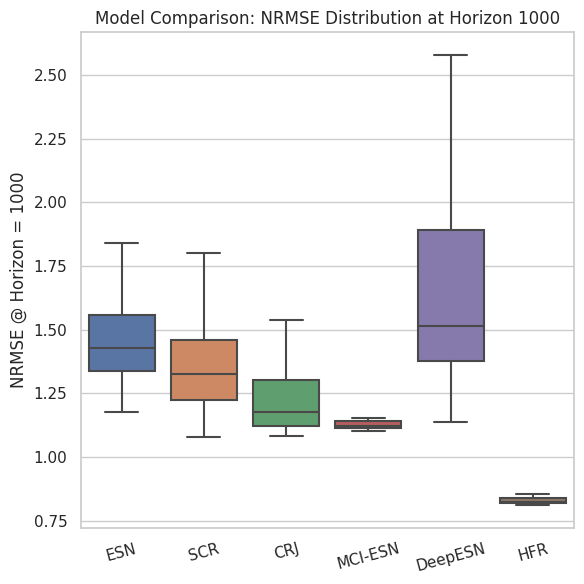

In [29]:
# import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set(style="whitegrid")

# Use integer key as your function returns {1000: value}
horizon = 1000
model_names = list(nrmse_dict.keys())

# Flatten NRMSEs for plotting
flattened_nrmse_data = {
    model: [entry[horizon] for entry in nrmse_dict[model]]
    for model in model_names
}

# Create boxplot
plt.figure(figsize=(6, 6))
sns.boxplot(data=[flattened_nrmse_data[model] for model in model_names], orient="v", showfliers=False)

plt.xticks(ticks=range(len(model_names)), labels=model_names, rotation=15)
plt.ylabel("NRMSE @ Horizon = 1000")
plt.title("Model Comparison: NRMSE Distribution at Horizon 1000")

# Save high-resolution image
plt.tight_layout()
plt.savefig("nrmse_boxplot_h1000_mit.png", dpi=250)
plt.show()

In [30]:
print("\nNRMSE for Different Prediction Horizons:")
print("-" * 140)
print(f"{'Horizon':<10} {'ESN':<17} {'SCR':<17} {'CRJ':<17} {'MCI-ESN':<17} {'DeepESN':<17} {'HFR':<17}")
print("-" * 140)


for horizon in all_horizons:
    esn_vals = [np.mean(esn_nrmse[horizon]) for esn_nrmse in nrmse_dict['ESN']]
    scr_vals = [np.mean(cycle_res_nrmse[horizon]) for cycle_res_nrmse in nrmse_dict['SCR']]
    crj_vals = [np.mean(crj_nrmse[horizon]) for crj_nrmse in nrmse_dict['CRJ']]
    # sw_vals  = [np.mean(sw_esn_nrmse[horizon]) for sw_esn_nrmse in nrmse_dict['SW-ESN']]
    mci_vals = [np.mean(mci_esn_nrmse[horizon]) for mci_esn_nrmse in nrmse_dict['MCI-ESN']]
    deep_vals = [np.mean(deepesn_nrmse[horizon]) for deepesn_nrmse in nrmse_dict['DeepESN']]
    # hypER_vals = [np.mean(hypER_nrmse[horizon]) for hypER_nrmse in nrmse_dict['HypER']]
    hfr_vals = [np.mean(hfr_nrmse[horizon]) for hfr_nrmse in nrmse_dict['HFR']]

    print(f"{horizon:<10}", end=" ")
    for vals in [esn_vals, scr_vals, crj_vals, mci_vals, deep_vals, hfr_vals]:
        mean = np.mean(vals)
        std = np.std(vals)
        print(f"{mean:.4f} ± {std:.4f}".ljust(18), end="")
    print()



NRMSE for Different Prediction Horizons:
--------------------------------------------------------------------------------------------------------------------------------------------
Horizon    ESN               SCR               CRJ               MCI-ESN           DeepESN           HFR              
--------------------------------------------------------------------------------------------------------------------------------------------
1000       1.4852 ± 0.2254   1.3715 ± 0.2000   1.2103 ± 0.1132   1.1262 ± 0.0156   1.6513 ± 0.4127   0.8302 ± 0.0192   


# Sunspot Dataset

In [24]:
import pandas as pd
file_path = 'datasets/SN_m_tot_V2.0.csv'

df = pd.read_csv(file_path, sep=';', header = None)
df

,0,1,2,3,4,5,6
0,1749,1,1749.042,96.7,-1.0,-1,1
1,1749,2,1749.123,104.3,-1.0,-1,1
2,1749,3,1749.204,116.7,-1.0,-1,1
3,1749,4,1749.288,92.8,-1.0,-1,1
4,1749,5,1749.371,141.7,-1.0,-1,1
...,...,...,...,...,...,...,...
3310,2024,11,2024.873,152.5,20.9,681,0
3311,2024,12,2024.958,154.5,25.6,572,0
3312,2025,1,2025.042,137.0,23.3,670,0
3313,2025,2,2025.122,154.6,23.3,655,0


In [25]:
data = df.iloc[:, 3].values
dt = 1
dataset_size = len(data)
data = create_delay_embedding(data, 3)
print(f"Dataset size: {dataset_size}")

# Train/Test Split
train_end = 2000
train_input  = data[:train_end]
train_target = data[1:train_end+1]
test_input   = data[train_end:-1]
test_target  = data[train_end+1:]
y_test = test_target
n_test_steps = len(test_target)
time_test = np.arange(n_test_steps) * dt

print(f"Train size: {len(train_input)}\nTest size: {len(test_input)}")

Dataset size: 3315
Train size: 2000
Test size: 1312


In [ ]:
all_horizons = list(range(10, 1001, 10))
all_horizons = [200, 500, 1000]

nrmse_dict = defaultdict(list)
seeds = range(995, 1000)


for seed in seeds:
    esn = BaselineESN3D(
        reservoir_size=300,
        spectral_radius=0.95,
        connectivity=0.05,
        input_scale=0.1,
        leaking_rate=0.8,
        ridge_alpha=1e-4,
        seed=seed
    )
    esn.fit_readout(train_input, train_target, discard=100)
    esn_preds = esn.predict(test_input)
    esn_nrmse = evaluate_nrmse(esn_preds, test_target, all_horizons)
    nrmse_dict['ESN'].append(esn_nrmse)


for seed in seeds:
    cycle_res = CycleReservoir3D(
        reservoir_size=300,
        cycle_weight = 0.8,
        spectral_radius=0.95,
        input_scale=0.4,
        leaking_rate=0.8,
        ridge_alpha=1e-4,
        seed=seed
    )
    cycle_res.fit_readout(train_input, train_target, discard=100)
    cycle_res_preds = cycle_res.predict(test_input)
    cycle_res_nrmse = evaluate_nrmse(cycle_res_preds, test_target, all_horizons)
    nrmse_dict['SCR'].append(cycle_res_nrmse)


for seed in seeds:
    crj = CRJRes3D(
        reservoir_size=300,
        edge_weight=0.8,
        jump=5,
        spectral_radius=0.95,
        input_scale=0.4,
        leaking_rate=0.8,
        ridge_alpha=1e-4,
        seed=seed
    )
    crj.fit_readout(train_input, train_target, discard=100)
    crj_preds = crj.predict(test_input)
    crj_nrmse = evaluate_nrmse(crj_preds, test_target, all_horizons)
    nrmse_dict['CRJ'].append(crj_nrmse)


# for seed in seeds:
#     sw_esn = SWRes3D(
#         reservoir_size=300,
#         rewiring_prob=0.2,
#         degree=6,
#         spectral_radius=0.95,
#         input_scale=0.3,
#         leaking_rate=0.8,
#         ridge_alpha=1e-4,
#         seed=seed
#     )
#     sw_esn.fit_readout(train_input, train_target, discard=100)
#     sw_esn_preds = sw_esn.predict(test_input)
#     sw_esn_nrmse = evaluate_nrmse(sw_esn_preds, test_target, all_horizons)
#     nrmse_dict['SW-ESN'].append(sw_esn_nrmse)


for seed in seeds:
    mci_esn = MCIESN3D(
        reservoir_size=300,
        cycle_weight=0.01,
        connect_weight=0.1,
        combine_factor=0.1,
        v1=0.0003,
        v2=0.0003,
        spectral_radius=0.95,
        leaking_rate=0.8,
        ridge_alpha=1e-4,
        seed=seed
    )
    mci_esn.fit_readout(train_input, train_target, discard=100)
    mci_esn_preds = mci_esn.predict(test_input)
    mci_esn_nrmse = evaluate_nrmse(mci_esn_preds, test_target, all_horizons)
    nrmse_dict['MCI-ESN'].append(mci_esn_nrmse)


for seed in seeds:
    deepesn = DeepESN3D(
        num_layers=3,
        reservoir_size=100,
        spectral_radius=0.95,
        input_scale=0.1,
        leaking_rate=0.6,
        ridge_alpha=1e-4,
        seed=seed
    )
    deepesn.fit_readout(train_input, train_target, discard=100)
    deepesn_preds = deepesn.predict(test_input)
    deepesn_nrmse = evaluate_nrmse(deepesn_preds, test_target, all_horizons)
    nrmse_dict['DeepESN'].append(deepesn_nrmse)


# for seed in seeds:
#     hypER = HypER3D(
#             reservoir_size=300,
#             disk_radius=0.99, 
#             sigma=0.1,
#             top_k=10,
#             spectral_radius=0.95,
#             input_scale=0.2,
#             leaking_rate=0.8,
#             ridge_alpha=1e-4,
#             seed=seed
#         )
#     hypER.fit_readout(train_input, train_target, discard=100)
#     hypER_preds = hypER.predict(test_input)
#     hypER_nrmse = evaluate_nrmse(hypER_preds, test_target, all_horizons)
#     nrmse_dict['HypER'].append(hypER_nrmse)

for seed in seeds:
    hfr = HFRRes3D(
        n_levels=8,      
        cells_per_level=[5, 10, 20, 25, 30, 35, 40, 60, 75, 90, 110],
        spectral_radius=0.2,
        input_scale=0.0001,
        leaking_rate=0.1,
        ridge_alpha=1e-8,
        seed=seed
    )
    hfr.fit_readout(train_input, train_target, discard=100)
    hfr_preds = hfr.predict_open_loop(test_input)
    hfr_nrmse = evaluate_nrmse(hfr_preds, test_target, all_horizons)
    nrmse_dict['HFR'].append(hfr_nrmse)

In [32]:
nrmse_dict

defaultdict(list,
            {'ESN': [{200: array([0.68419654, 0.68307397, 0.68055338]),
               500: array([0.55808431, 0.55372415, 0.55032945]),
               1000: array([0.48667682, 0.48668022, 0.486711  ])},
              {200: array([0.67116865, 0.67006745, 0.66759486]),
               500: array([0.63489179, 0.62993155, 0.62606964]),
               1000: array([0.54938674, 0.54939058, 0.54942532])},
              {200: array([0.74582   , 0.74459632, 0.74184871]),
               500: array([0.60049699, 0.59580546, 0.59215278]),
               1000: array([0.54500365, 0.54500746, 0.54504192])},
              {200: array([0.66923076, 0.66813274, 0.66566729]),
               500: array([0.55675167, 0.55240191, 0.54901532]),
               1000: array([0.49582128, 0.49582475, 0.4958561 ])},
              {200: array([0.72864949, 0.72745398, 0.72476963]),
               500: array([0.61248525, 0.60770007, 0.60397446]),
               1000: array([0.53740633, 0.53741009, 0.537

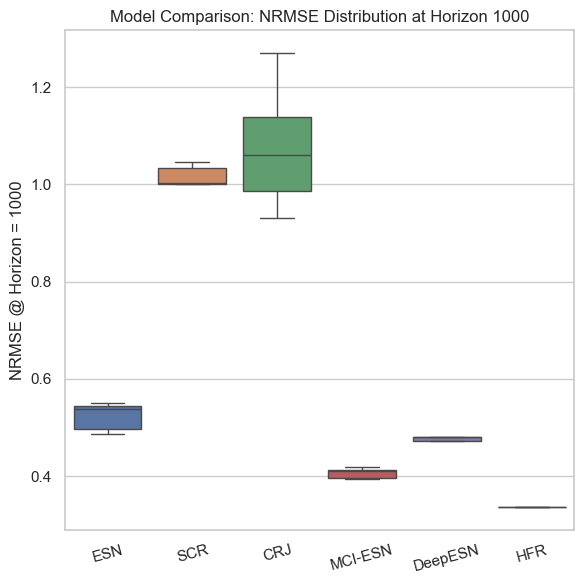

In [35]:
# import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set(style="whitegrid")

# Use integer key as your function returns {1000: value}
horizon = 1000
model_names = list(nrmse_dict.keys())

# Flatten NRMSEs for plotting
flattened_nrmse_data = {
    model: np.concatenate([entry[horizon] for entry in nrmse_dict[model]])
    for model in model_names
}

# Create boxplot
plt.figure(figsize=(6, 6))
sns.boxplot(data=[flattened_nrmse_data[model] for model in model_names], orient="v", showfliers=False)

plt.xticks(ticks=range(len(model_names)), labels=model_names, rotation=15)
plt.ylabel("NRMSE @ Horizon = 1000")
plt.title("Model Comparison: NRMSE Distribution at Horizon 1000")

# Save high-resolution image
plt.tight_layout()
plt.savefig("nrmse_boxplot_h1000_sun.png", dpi=250)
plt.show()


In [ ]:
print("\nNRMSE for Different Prediction Horizons:")
print("-" * 140)
print(f"{'Horizon':<10} {'ESN':<17} {'SCR':<17} {'CRJ':<17} {'MCI-ESN':<17} {'DeepESN':<17} {'HFR':<17}")
print("-" * 140)


for horizon in horizons:
    esn_vals = [np.mean(esn_nrmse[horizon]) for esn_nrmse in nrmse_dict['ESN']]
    scr_vals = [np.mean(cycle_res_nrmse[horizon]) for cycle_res_nrmse in nrmse_dict['SCR']]
    crj_vals = [np.mean(crj_nrmse[horizon]) for crj_nrmse in nrmse_dict['CRJ']]
    # sw_vals  = [np.mean(sw_esn_nrmse[horizon]) for sw_esn_nrmse in nrmse_dict['SW-ESN']]
    mci_vals = [np.mean(mci_esn_nrmse[horizon]) for mci_esn_nrmse in nrmse_dict['MCI-ESN']]
    deep_vals = [np.mean(deepesn_nrmse[horizon]) for deepesn_nrmse in nrmse_dict['DeepESN']]
    # hypER_vals = [np.mean(hypER_nrmse[horizon]) for hypER_nrmse in nrmse_dict['HypER']]
    hfr_vals = [np.mean(hfr_nrmse[horizon]) for hfr_nrmse in nrmse_dict['HFR']]

    print(f"{horizon:<10}", end=" ")
    for vals in [esn_vals, scr_vals, crj_vals, mci_vals, deep_vals, hfr_vals]:
        mean = np.mean(vals)
        std = np.std(vals)
        print(f"{mean:.4f} ± {std:.4f}".ljust(18), end="")
    print()

# Sante Fe Dataset

In [21]:
import pandas as pd

file_path = 'datasets/santa-fe-time-series-competition-data-set-b-1.0.0/b1.txt'

df = pd.read_csv(file_path, header=None, sep=' ')
df

,0,1,2,3
0,76.53,8320,7771,NaN
1,76.53,8117,7774,NaN
2,76.15,7620,7788,NaN
3,75.39,6413,7787,NaN
4,75.51,7518,7767,NaN
...,...,...,...,...
16995,73.57,16021,6498,NaN
16996,73.79,-6957,6547,NaN
16997,74.54,11476,6576,NaN
16998,74.36,15058,6573,NaN


In [22]:
# Normalize the first column (column 0) of the DataFrame
df[0] = (df[0] - df[0].min()) / (df[0].max() - df[0].min())

In [23]:
data = df.iloc[:, 0].values
chosen_system = "SantaFe"
dt = 1
T_data = len(data)
data = create_delay_embedding(data, 3)
print(f"Data length: {T_data}.")

# Train/Test Split
train_end = 7000
train_input  = data[:train_end]
train_target = data[1:train_end+1]
test_input   = data[train_end:-1]
test_target  = data[train_end+1:]
y_test = test_target
n_test_steps = len(test_target)
time_test = np.arange(n_test_steps) * dt

print(f"Train size: {len(train_input)}  \nTest size: {len(test_input)}")


Data length: 17000.
Train size: 7000  
Test size: 9997


In [37]:
all_horizons = list(range(10, 1001, 10))
horizons = [200, 500, 1000]

nrmse_dict = defaultdict(list)
seeds = range(995, 1025)

for seed in seeds:
    esn = BaselineESN3D(
        reservoir_size=300,
        spectral_radius=0.95,
        connectivity=0.05,
        input_scale=0.1,
        leaking_rate=0.8,
        ridge_alpha=1e-4,
        seed=seed
    )
    esn.fit_readout(train_input, train_target, discard=100)
    esn_preds = esn.predict(test_input)
    esn_nrmse = evaluate_nrmse(esn_preds, test_target, horizons)
    nrmse_dict['ESN'].append(esn_nrmse)


for seed in seeds:
    cycle_res = CycleReservoir3D(
        reservoir_size=300,
        cycle_weight = 0.8,
        spectral_radius=0.99,
        input_scale=0.4,
        leaking_rate=0.8,
        ridge_alpha=1e-4,
        seed=seed
    )
    cycle_res.fit_readout(train_input, train_target, discard=100)
    cycle_res_preds = cycle_res.predict(test_input)
    cycle_res_nrmse = evaluate_nrmse(cycle_res_preds, test_target, horizons)
    nrmse_dict['SCR'].append(cycle_res_nrmse)


for seed in seeds:
    crj = CRJRes3D(
        reservoir_size=500,
        edge_weight=0.8,
        jump=15,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-6,
        seed=seed
    )
    crj.fit_readout(train_input, train_target, discard=100)
    crj_preds = crj.predict(test_input)
    crj_nrmse = evaluate_nrmse(crj_preds, test_target, horizons)
    nrmse_dict['CRJ'].append(crj_nrmse)


# for seed in seeds:
#     sw_esn = SWRes3D(
#         reservoir_size=300,
#         rewiring_prob=0.2,
#         degree=6,
#         spectral_radius=0.95,
#         input_scale=0.3,
#         leaking_rate=0.8,
#         ridge_alpha=1e-4,
#         seed=seed
#     )
#     sw_esn.fit_readout(train_input, train_target, discard=100)
#     sw_esn_preds = sw_esn.predict(test_input)
#     sw_esn_nrmse = evaluate_nrmse(sw_esn_preds, test_target, all_horizons)
#     nrmse_dict['SW-ESN'].append(sw_esn_nrmse)


for seed in seeds:
    mci_esn = MCIESN3D(
        reservoir_size=300,
        cycle_weight=1,
        connect_weight=1,
        combine_factor=0.5,
        v1=0.8,
        v2=0.8,
        spectral_radius=0.95,
        leaking_rate=0.8,
        ridge_alpha=1e-4,
        seed=seed
    )
    mci_esn.fit_readout(train_input, train_target, discard=100)
    mci_esn_preds = mci_esn.predict(test_input)
    mci_esn_nrmse = evaluate_nrmse(mci_esn_preds, test_target, horizons)
    nrmse_dict['MCI-ESN'].append(mci_esn_nrmse)


for seed in seeds:
    deepesn = DeepESN3D(
        num_layers=3,
        reservoir_size=100,
        spectral_radius=0.95,
        input_scale=0.2,
        leaking_rate=0.9,
        ridge_alpha=1e-4,
        seed=seed
    )
    deepesn.fit_readout(train_input, train_target, discard=100)
    deepesn_preds = deepesn.predict(test_input)
    deepesn_nrmse = evaluate_nrmse(deepesn_preds, test_target, horizons)
    nrmse_dict['DeepESN'].append(deepesn_nrmse)


# for seed in seeds:
#     hypER = HypER3D(
#             reservoir_size=300,
#             disk_radius=0.99, 
#             sigma=0.1,
#             top_k=15,
#             spectral_radius=0.95,
#             input_scale=0.2,
#             leaking_rate=0.8,
#             ridge_alpha=1e-6,
#             seed=seed
#         )
#     hypER.fit_readout(train_input, train_target, discard=100)
#     hypER_preds = hypER.predict(test_input)
#     hypER_nrmse = evaluate_nrmse(hypER_preds, test_target, all_horizons)
#     nrmse_dict['HypER'].append(hypER_nrmse)

for seed in seeds:
    hfr = HFRRes3D(
        n_levels=8,      
        cells_per_level=[5, 10, 20, 25, 30, 35, 40, 60, 75, 90, 110],
        spectral_radius=0.01,
        input_scale=0.1,
        leaking_rate=0.1,
        ridge_alpha=1e-8,
        seed=seed
    )
    hfr.fit_readout(train_input, train_target, discard=2000)
    hfr_preds = hfr.predict_open_loop(test_input)
    hfr_nrmse = evaluate_nrmse(hfr_preds, test_target, horizons)
    nrmse_dict['HFR'].append(hfr_nrmse)

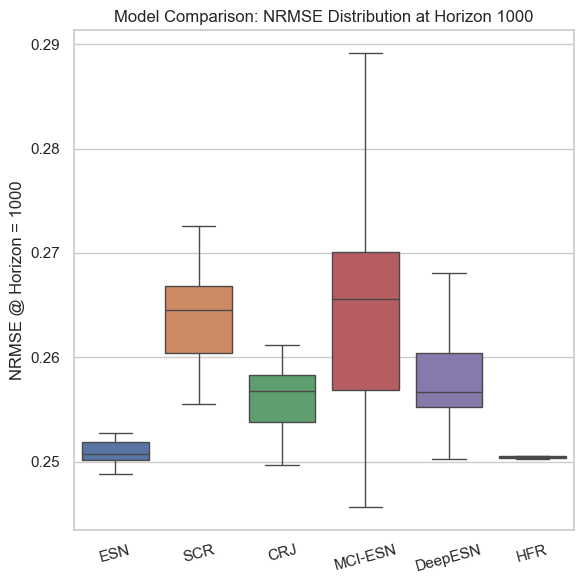

In [38]:
# import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set(style="whitegrid")

# Use integer key as your function returns {1000: value}
horizon = 1000
model_names = list(nrmse_dict.keys())

# Flatten NRMSEs for plotting
flattened_nrmse_data = {
    model: np.concatenate([entry[horizon] for entry in nrmse_dict[model]])
    for model in model_names
}

# Create boxplot
plt.figure(figsize=(6, 6))
sns.boxplot(data=[flattened_nrmse_data[model] for model in model_names], orient="v", showfliers=False)

plt.xticks(ticks=range(len(model_names)), labels=model_names, rotation=15)
plt.ylabel("NRMSE @ Horizon = 1000")
plt.title("Model Comparison: NRMSE Distribution at Horizon 1000")

# Save high-resolution image
plt.tight_layout()
plt.savefig("nrmse_boxplot_h1000_santa.png", dpi=250)
plt.show()


In [ ]:
print("\nNRMSE for Different Prediction Horizons:")
print("-" * 140)
print(f"{'Horizon':<10} {'ESN':<17} {'SCR':<17} {'CRJ':<17} {'MCI-ESN':<17} {'DeepESN':<17} {'HFR':<17}")
print("-" * 140)


for horizon in horizons:
    esn_vals = [np.mean(esn_nrmse[horizon]) for esn_nrmse in nrmse_dict['ESN']]
    scr_vals = [np.mean(cycle_res_nrmse[horizon]) for cycle_res_nrmse in nrmse_dict['SCR']]
    crj_vals = [np.mean(crj_nrmse[horizon]) for crj_nrmse in nrmse_dict['CRJ']]
    # sw_vals  = [np.mean(sw_esn_nrmse[horizon]) for sw_esn_nrmse in nrmse_dict['SW-ESN']]
    mci_vals = [np.mean(mci_esn_nrmse[horizon]) for mci_esn_nrmse in nrmse_dict['MCI-ESN']]
    deep_vals = [np.mean(deepesn_nrmse[horizon]) for deepesn_nrmse in nrmse_dict['DeepESN']]
    # hypER_vals = [np.mean(hypER_nrmse[horizon]) for hypER_nrmse in nrmse_dict['HypER']]
    hfr_vals = [np.mean(hfr_nrmse[horizon]) for hfr_nrmse in nrmse_dict['HFR']]

    print(f"{horizon:<10}", end=" ")
    for vals in [esn_vals, scr_vals, crj_vals, mci_vals, deep_vals, hfr_vals]:
        mean = np.mean(vals)
        std = np.std(vals)
        print(f"{mean:.4f} ± {std:.4f}".ljust(18), end="")
    print()